# Accessing Global Forecast System (GFS) data and simple visualization

### References:
- https://www.nco.ncep.noaa.gov/pmb/products/gfs/#GFS

#### Define a function `file_path()` to fetch the urls in public Azure container

In [1]:
import os

def file_path(cycle_runtime:str, forecast_hour:str, year:int, month:str, day:str, resolution_degree:float) -> str:
    
    prefix_path = "https://noaagfs.blob.core.windows.net/"
    product_name = "gfs"
    
    if len(cycle_runtime) == 1:
        cycle_runtime = cycle_runtime.rjust(2, '0')

    if len(forecast_hour) != 3:
        forecast_hour = forecast_hour.rjust(3, '0')

    if len(month) == 1:
        month = month.rjust(2, '0')

    if len(day) == 1:
        day = day.rjust(2, '0')

    if len(str(resolution_degree).split('.')[1]) == 1:
        split_resolution_degree = []
        split_resolution_degree.append(str(resolution_degree).split('.')[0])
        split_resolution_degree.append(str(resolution_degree).split('.')[1].ljust(2, '0'))
    else:
        split_resolution_degree = str(resolution_degree).split('.')

    file_path = (
            f"{product_name}/{product_name}.{year}{month}{day}/"
            f"{cycle_runtime}/atmos/{product_name}.t{cycle_runtime}z."
            f"pgrb2.{split_resolution_degree[0]}p{split_resolution_degree[1]}.f{forecast_hour}"
            )
    
    whole_path = os.path.join(prefix_path, file_path)

    return whole_path


#### Define a function `read_into_xarray_dataset()` to read given url into xarray dataset

References for different keywords:

        filter_by_keys={'typeOfLevel': 'meanSea'}
        filter_by_keys={'typeOfLevel': 'hybrid'}
        filter_by_keys={'typeOfLevel': 'atmosphere', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'atmosphere', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'accum'}
        filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}
        filter_by_keys={'typeOfLevel': 'isobaricInPa'}
        filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
        filter_by_keys={'typeOfLevel': 'heightAboveGround'}
        filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
        filter_by_keys={'typeOfLevel': 'heightAboveSea'}
        filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
        filter_by_keys={'typeOfLevel': 'lowCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'lowCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'middleCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'middleCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'highCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'highCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'cloudCeiling'}
        filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
        filter_by_keys={'typeOfLevel': 'tropopause'}
        filter_by_keys={'typeOfLevel': 'maxWind'}
        filter_by_keys={'typeOfLevel': 'isothermZero'}
        filter_by_keys={'typeOfLevel': 'highestTroposphericFreezing'}
        filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
        filter_by_keys={'typeOfLevel': 'sigmaLayer'}
        filter_by_keys={'typeOfLevel': 'sigma'}
        filter_by_keys={'typeOfLevel': 'potentialVorticity'}
 

In [2]:
import xarray as xr
import urllib.request
from urllib.error import HTTPError
from typing import Optional

def read_into_xarray_dataset(URL:str, level:str, step:Optional[str] = None):
    
    try:
        filename, _ = urllib.request.urlretrieve(URL)

        step_key = ['atmosphere', 'surface', 'lowCloudLayer', 'middleCloudLayer', 'highCloudLayer']
        
        if level in step_key:
            ds = xr.open_dataset(filename, engine="cfgrib", filter_by_keys={'typeOfLevel': level, 'stepType': step}, backend_kwargs = {'errors' : 'ignore'})
        else:
            ds = xr.open_dataset(filename, engine="cfgrib", filter_by_keys={'typeOfLevel': level}, backend_kwargs = {'errors' : 'ignore'})
        
        return ds

    except HTTPError as err:

        if err.code == 404:
            
            print(f"{URL} does not exist. Please check the parameters again.")

In [3]:
URL = file_path('12', '102', 2024, '6', '10', 0.5)
ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

print(URL)
ds

https://noaagfs.blob.core.windows.net/gfs/gfs.20240610/12/atmos/gfs.t12z.pgrb2.0p50.f102


<xarray.Dataset>
Dimensions:                  (latitude: 361, longitude: 720)
Coordinates:
    time                     datetime64[ns] ...
    step                     timedelta64[ns] ...
    pressureFromGroundLayer  float64 ...
  * latitude                 (latitude) float64 90.0 89.5 89.0 ... -89.5 -90.0
  * longitude                (longitude) float64 0.0 0.5 1.0 ... 359.0 359.5
    valid_time               datetime64[ns] ...
Data variables:
    t                        (latitude, longitude) float32 ...
    r                        (latitude, longitude) float32 ...
    q                        (latitude, longitude) float32 ...
    u                        (latitude, longitude) float32 ...
    v                        (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-06-12T15:32 GRIB to CDM+CF via cfgrib-0.9.1...

#### filtering the dataset with US boundary, converting it into pandas dataframe and rename and reorder the columns.

In [4]:
df_usa = (ds[['t', 'r', 'q', 'u', 'v']]
          .sel(latitude = slice(50, 24), longitude = slice(235, 293))
          .to_dataframe()
          .sort_values('latitude')
          .reset_index()
          )

df_usa.rename(columns = {'t' : ds['t'].standard_name, 
                         'r' : ds['r'].standard_name, 
                         'q' : ds['q'].standard_name, 
                         'u' : ds['u'].standard_name, 
                         'v' : ds['v'].standard_name}, inplace = True
                         )

df_usa.drop('valid_time', axis = 1, inplace = True)
df_usa = df_usa.iloc[:, [7,8,9,0,1,2,3,4,5,6]]

df_usa.head()

,time,step,pressureFromGroundLayer,latitude,longitude,air_temperature,relative_humidity,specific_humidity,eastward_wind,northward_wind
0,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,293.0,298.419312,78.099998,0.015718,-5.080725,0.213931
1,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,250.0,302.619324,45.700001,0.012068,-2.380725,-1.416069
2,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,250.5,297.619324,79.300003,0.015349,-5.110725,5.593931
3,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,251.0,297.719299,83.099998,0.016165,-2.670725,6.443931
4,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,251.5,298.219299,81.900002,0.016447,-0.340725,5.783931


#### Simple visualization of gfs data

Running |████████████████████| 6/6 [100%] in 54.5s (0.10/s)                     


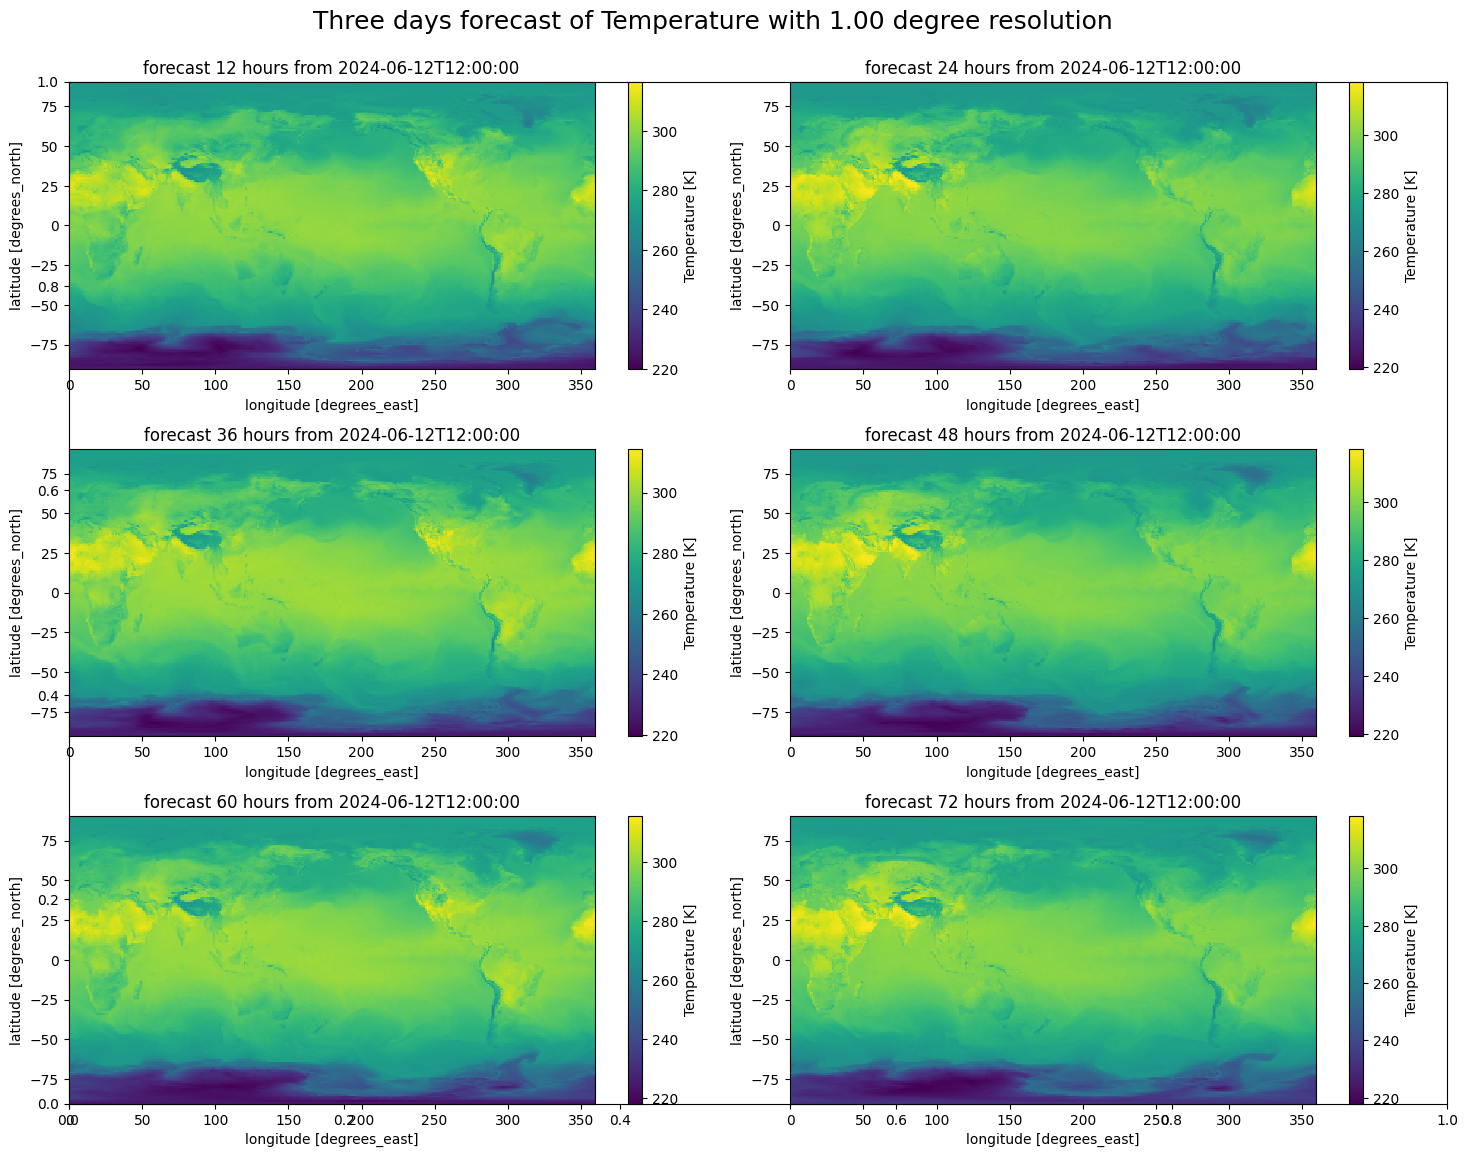

In [64]:
import matplotlib.pyplot as plt
from alive_progress import alive_bar

forecast_hours = [str(x) for x in range(12, 72 + 1, 12)]
fig = plt.subplots(figsize = (15, 12))

with alive_bar(len(forecast_hours), force_tty=True, title='Running', length=20, bar = 'smooth') as bar:
    
    for n, forecast_hour in enumerate(forecast_hours):
        
        URL = file_path('12', forecast_hour, 2024, '06', '12', 1.00)

        ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

        ax = plt.subplot(3, 2, n + 1)
        
        ds['t'].plot(ax = ax)

        plt.title(f"forecast {ds.step.values.astype('timedelta64[h]')} from {ds.time.values.astype('datetime64[s]')}")  

        bar()

plt.suptitle('Three days forecast of Temperature with 1.00 degree resolution', size = 18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()


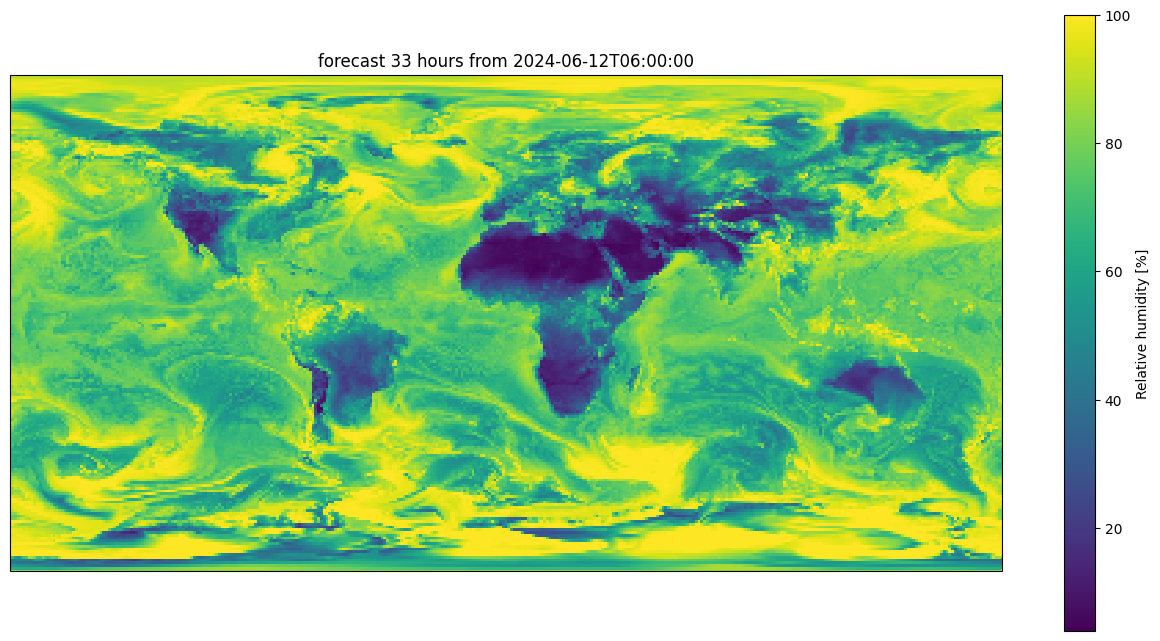

In [47]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ds['r'].plot(ax = ax)
plt.title(f"forecast {ds.step.values.astype('timedelta64[h]')} from {ds.time.values.astype('datetime64[s]')}")
plt.show()